# Прогнозирование оттока клиентов банка

В «Бета-Банке» решили обратить внимание на отток клиентов. Банковские маркетологи определили, что сохранять текущих клиентов дешевле, чем привлекать новых.

**Задача исследования** - на основе имеющихся исторических данных о поведении клиентов и расторжении договоров с банком построить модель, которая с максимальным значением выбранной метрики (F1-меры) даст прогноз, уйдёт ли клиент из банка в ближайшее время или нет.

По условию задания необходимо получить модель, метрика (F1-мера) которой, составит не менее 0.59. Дополнительно качество модели необходимо также оценить по RОС-AUC и сравнить этот показатель с F1-мерой.

**Описание имеющихся данных**

* **Датасет из файла** **`Сhurn.csv`** (каждый объект в наборе данных - это информация о клиенте банка с уникальным идентификатором) содержит следующие признаки:
    * `RowNumber` —  индекс строки в данных;
    * `CustomerId` — уникальный идентификатор клиента;
    * `Surname` — фамилия клиента;
    * `CreditScore` — кредитный рейтинг;
    * `Geography` — страна проживания клиента;
    * `Gender` — пол клиента;
    * `Age` — возраст клиента;
    * `Tenure` — сколько лет человек является клиентом банка;
    * `Balance` — текущий баланс на счёте клиента;
    * `NumOfProducts` — количество продуктов банка, используемых клиентом;
    * `HasCrCard` — наличие кредитной карты у клиента;
    * `IsActiveMember` — активность клиента;
    * `EstimatedSalary` — предполагаемая зарплата.


* **Целевой признак** в данных:
    * `Exited` — факт ухода клиента.
    

Это всё, что известно о данных. Поэтому, перед обучением моделей и оценкой их качества понадобится расширенный обзор данных и при необходимости их предобработка.

Исследование будет проведено в шесть этапов:
1. Обзор данных.
2. Исследование и предобработка данных.
3. Разбиение на выборки и обучение на несбалансированных данных.
4. Работа с дисбалансом, обучение, валидация и тестирование моделей.
5. Финальное тестирование.
6. Общие выводы.

## Обзор и изучение данных

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, r2_score, auc
from sklearn.metrics import roc_curve 
from sklearn.utils import shuffle

sns.set_style('darkgrid')

pd.options.mode.chained_assignment = None

# чтение из файла с данными
df = pd.read_csv('/datasets/Churn.csv')

### Обзор данных

Посмотрим на общий вид, сводную информацию, проверим количество пропущенных значений и наличие дубликатов в предоставленных для исследования исторических данных из файла `Churn.csv`.

In [2]:
# вывод первых строк данных из файла
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
# просмотр сводной информации о данных из файла
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
# проверка количества уникальных значений целевого признака
df['Exited'].nunique()

2

In [5]:
# просмотр распределения целевого признака по его значениям
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [6]:
# проверка данных на количество пропусков
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [7]:
# подсчёт доли пропусков по отношению ко всем данным
df.isna().sum() / df.shape[0]

RowNumber          0.0000
CustomerId         0.0000
Surname            0.0000
CreditScore        0.0000
Geography          0.0000
Gender             0.0000
Age                0.0000
Tenure             0.0909
Balance            0.0000
NumOfProducts      0.0000
HasCrCard          0.0000
IsActiveMember     0.0000
EstimatedSalary    0.0000
Exited             0.0000
dtype: float64

In [8]:
# проверка на полные дубликаты в данных
print('Количество полных дублированных строк:', df.duplicated().sum())

Количество полных дублированных строк: 0


### Выводы по обзору данных

* Данные успешно загружены и проведено предварительное знакомство с ними. Таблица содержит `10000` записей. Полных дубликатов в данных нет, но присутствуют пропущенные значения в стобце `Tenure`,  и многочисленные нарушения стиля заголовков.
* Данные в столбце `RowNumber` (индекс строки в данных) дублируют индексы таблицы со значениями `index + 1` и не содержат полезной информации, которая может быть использована при обучении моделей. По этой причине их можно полностью удалить. Аналочиная ситуация с данными по `CustomerId` (уникальным идентификаторам клиентов) и `Surname` (фамилиям клиентов).
* Данные по тому, сколько лет человек является клиентом банка (столбец `Tenure`) содержит немногим более `9%` пропущенных значений от всего количества данных.
* Таблица содержит два признака `Geography` (страна проживания клиента) и `Gender` (пол клиента) с типом данных `object`. Остальные данные представлены в числовом виде с типами `float64` или `int64`.
* Категориальный признак `Exited` (факт ухода клиента) имеет тип данных `int64` и представлен значениями `0` (клиент не ушёл) и `1` (клиент ушёл из банка).

## Исследование и предобработка данных

### Предобработка данных

Удалим столбцы `RowNumber` (индекс строки в данных), `CustomerId` (уникальные идентификаторы клиентов) и `Surname` (фамилии клиентов) из данных.

In [9]:
# удаление столбцов RowNumber, CustomerId и Surname
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

Приведём все названия для оставшихся столбцов в таблице к их соотвествию змеиному стилю.

In [10]:
# получение списка заголовков в змеином стиле
columns = df.columns

snake_case_columns = {}

for column in columns:
    snake_case_str = ''
    for letter in column:
        if letter != column[:1] and letter == letter.upper():
            snake_case_str += f'_{letter.lower()}'
        else:
            snake_case_str += letter
    snake_case_columns[column] = snake_case_str.lower()

# просмотр полученного словаря
snake_case_columns

{'CreditScore': 'credit_score',
 'Geography': 'geography',
 'Gender': 'gender',
 'Age': 'age',
 'Tenure': 'tenure',
 'Balance': 'balance',
 'NumOfProducts': 'num_of_products',
 'HasCrCard': 'has_cr_card',
 'IsActiveMember': 'is_active_member',
 'EstimatedSalary': 'estimated_salary',
 'Exited': 'exited'}

In [11]:
# переименование столбцов по полученному словарю с помощью метода rename()
df = df.rename(columns=snake_case_columns)

# просмотр первых строк таблицы после переименования
df.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


* Столбцы `RowNumber` (индекс строки в данных), `CustomerId` (уникальные идентификаторы клиентов) и `Surname` (фамилии клиентов), данные в которых не содержат полезной информации для обучения моделей успешно удалены из таблицы.
* Названия столбцов приведены к соотвествию змениному стилю.

### Изучение количественных признаков

Изучим все количественные признаки из таблицы. Для этого посмотрим на их основные описательные статистики, посмотрим на графики распределения частот для этих количественных признаков, постром графики размаха, чтобы оценить наличие аномальных значений.

In [12]:
# составление списка названий колонок для количественных признаков
digit_features = ['credit_score', 'age', 'balance', 'estimated_salary']

In [13]:
# просмотр описательных статистик по количественным признакам
df[digit_features].describe()

,credit_score,age,balance,estimated_salary
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,76485.889288,100090.239881
std,96.653299,10.487806,62397.405202,57510.492818
min,350.000000,18.000000,0.000000,11.580000
25%,584.000000,32.000000,0.000000,51002.110000
50%,652.000000,37.000000,97198.540000,100193.915000
75%,718.000000,44.000000,127644.240000,149388.247500
max,850.000000,92.000000,250898.090000,199992.480000


По признакам `credit_score` (кредитный рейтинг), `age` (возраст клиента) и `estimated_salary` (предполагаемая зарплата) медианные и средние значения отличаются незначительно. Для признака `balance` (текущий баланс на счёте клиента) среднее значение значительно меньше медианного, что говорит о скосе данных влево.

In [14]:
# функция для построения парных графиков в виде гистограмм распределения частот и диаграмм размаха
def pair_chart(data, column_name):
    """
    input: data (pandas.Series)   - данные для построения гистограммы и ящика с усами
           column_name (str)      - наименование столбца данных
    output: None
    description: Функция для построения парных графиков для исследуемого параметра:
                 - Первый график гистограмма отображает распределение частот с помощью параметра stat = frequency
                 - Вторая график диаграмма размаха отображает максимальные границы выборки и выбросы 
    """

    labels = {'credit_score': 'Кредитный рейтинг',
              'age': 'Возраст',
              'balance': 'Баланс на счёте',
              'estimated_salary': 'Предполагаемая зарплата'
              }

    sns.set()
    sns.set_palette(palette='CMRmap')
    f, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(labels[column_name] +
                      '. Гистограмма частот.', fontsize=14)
    axes[0].set_ylabel('Количество', fontsize=13)
    axes[0].set_xlabel(labels[column_name], fontsize=13)
    sns.histplot(data, bins=25, alpha=0.5, kde=True,
                 ax=axes[0], stat='frequency')

    axes[1].set_title(labels[column_name] +
                      '. Диаграмма размаха.', fontsize=14)
    axes[1].set_xlabel('', fontsize=13)
    sns.boxplot(x=data, orient='h', ax=axes[1], palette='BuPu')

    plt.show()

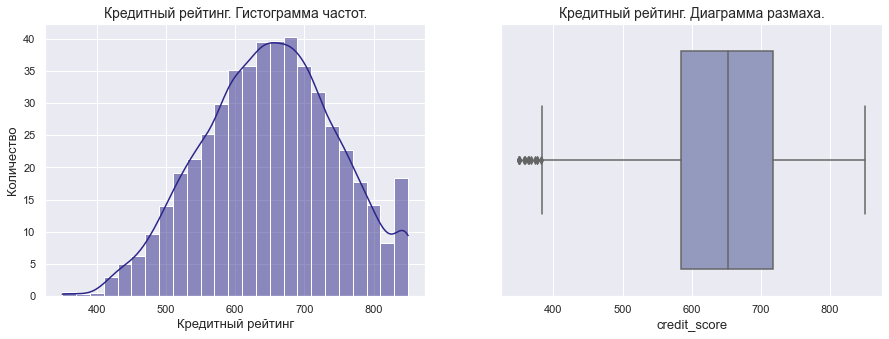

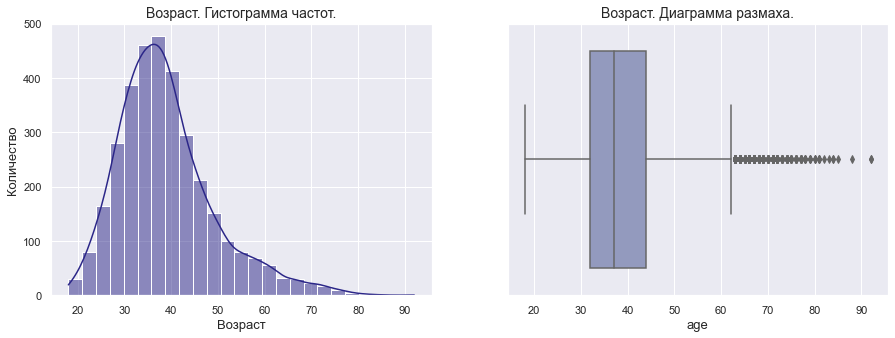

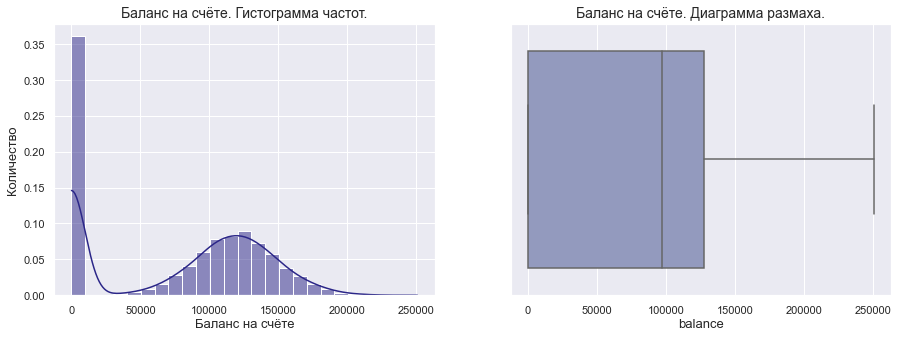

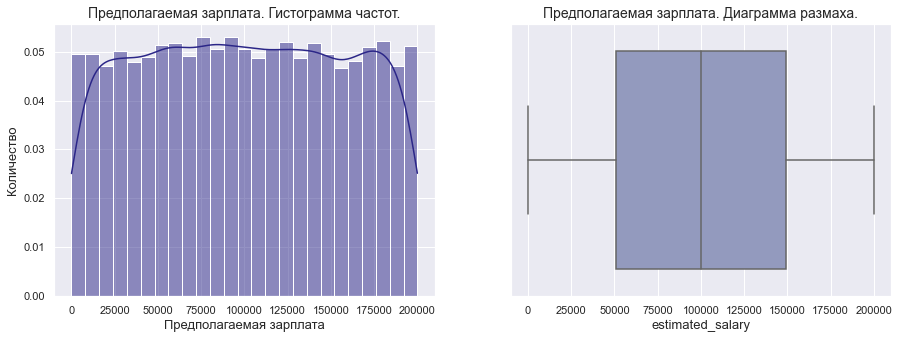

In [15]:
# построение графиков для количественных признаков
for column in df[digit_features].columns:
    pair_chart(df[column], column)

Смещение среднего значения баланса влево от медианного обусловлено большим количеством клиентов с нулевым текущим балансом на счёте `balanсe`. Определим долю таких клиентов среди всех клиентов банка.

In [16]:
# определим долю клиентов с нулевым текущим балансом в банке
df.loc[df['balance'] == 0].shape[0] / df.shape[0]

0.3617

Судя по диаграммам размаха, данные по `credit_score` (кредитному рейтингу) имеют выбросы, находящиеся за левой границей, то есть в областях минимальных значений, а данные по `age` (возрасту клиента) наоборот за правой границей, то есть в областях максимальных значений. Оценим долю выбросов по отношению к всем имеющимся данным. Для этого создадим пару вспомогательных функций:
* `outliers_value()` - для определения границы, за которой будут находится выбросы;
* `outliers_rate()` - определения количества и доли выбросов по отношению ко всем данным.

In [17]:
# вспомогательная функция для определения границы выбросов
def outliers_value(column_name):
    """
    input: column_name (str)      - название столбца (параметра, для которого будет определяться граница)
    output: val        (float)    - значение верхней границы, за которой будут находится выбросы
    description: Функция находит и возвращает значение границ для исследуемого параметра за которыми будут 
                 находится выбросы
    """
    # получение расчётных значений границ
    val_max = df[column_name].describe()['75%'] + (df[column_name].describe()
                                               ['75%'] - df[column_name].describe()['25%']) * 1.5
    val_min = df[column_name].describe()['25%'] - (df[column_name].describe()
                                               ['75%'] - df[column_name].describe()['25%']) * 1.5
    # проверка на превышение расчётных границ над фактическими значениями
    if val_max > df[column_name].max():
        val_max = df[column_name].max()
    if val_min < df[column_name].min():
        val_min = df[column_name].min()
    
    return val_min, val_max

In [18]:
# пустой словарь для последующего хранения значений выбросов по ключам в виде имён параметров
outliers_values = {}

# сохранение значений границ выбросов в словарь max_vals с помощью функции outliers_value()
for column in digit_features:
    outliers_values[column] = outliers_value(column)

# просмотр полученного словаря
outliers_values

{'credit_score': (383.0, 850),
 'age': (18, 62.0),
 'balance': (0.0, 250898.09),
 'estimated_salary': (11.58, 199992.48)}

In [19]:
# вспомогательная функция для определения количества и доли выбросов
def outliers_rate(column_name, outliers_values=outliers_values):
    """
    input: column_name  (str)      - название столбца (параметра, для которого будут находится количество и доля выбросов)
           outliers_values (dict)  - словарь с границами выбросов
    output: print() значениями количества и доли выбросов
    description: Функция расчитывает и выводит на печать значения количества и доли выбросов по отношению ко всем данным
    """
    outliers_count_max = df.loc[df[column] > outliers_values[column][1]].shape[0]
    outliers_count_min = df.loc[df[column] < outliers_values[column][0]].shape[0]
    outliers_count = outliers_count_max + outliers_count_min
    rate = round(outliers_count / df.shape[0] * 100, 2)
    print(f'Количество выбросов для параметра «{column_name}» равно: {outliers_count} ({rate}%)')

In [20]:
for column in digit_features:
    outliers_rate(column)

Количество выбросов для параметра «credit_score» равно: 15 (0.15%)
Количество выбросов для параметра «age» равно: 359 (3.59%)
Количество выбросов для параметра «balance» равно: 0 (0.0%)
Количество выбросов для параметра «estimated_salary» равно: 0 (0.0%)


In [21]:
# масштабирование количественных признаков
#scaler = StandardScaler()
#df[digit_features] = scaler.fit_transform(df[digit_features])

* Данные о текущем балансе на счёте содержат большое количество нулевых значений - `36.2%`. Они образуют в данных выраженное смещение средних значений влево от медианы. Таким образом, более трети клиентов банка имеют нулевой баланс на счёте и являются важной категорией, в которой доля ушедших клиентов может быть выше по сравнению с остальными данными.
* Наибольшее количество выбросов `3.6%` наблюдается для признака возраст `age`. Доля выбросов небольшая и они оставлены как есть.

### Изучение категориальных признаков

Для изучения категориальных признаков построим графики количества значений различных категорий в данном признаке. Для этого создадим вспомогательную функцию *show_double_countplots()*.

In [22]:
# функция для построения парных графиков количества значений категорий в признаке
def show_double_countplots(label_first, label_second):
    """
    input: data (pandas.Series)             - данные для построения графиков
           label_first, label_second (str)  - названия признаков
    output: None
    description: Функция для построения парных графиков методом countplots() для двух признаков
    """
    
    labels = {'geography': 'Cтрана проживания',
              'gender': 'Пол клиента',
              'tenure': 'Сколько лет человек является клиентом банка',
              'num_of_products': 'Количество используемых банковских продуктов',
              'has_cr_card': 'Наличие кредитной карты',
              'is_active_member': 'Активность клиента'
              }
    
    
    sns.set()
    sns.set_palette(palette='tab20c_r')
    f, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(labels[label_first], fontsize=15)
    sns.countplot(data=df, x=label_first, ax=axes[0])
    axes[0].set_xlabel(labels[label_first], fontsize=13)
    axes[0].set_ylabel('Количество', fontsize=13)

    axes[1].set_title(labels[label_second], fontsize=15)
    sns.countplot(data=df, x=label_second, ax=axes[1])
    axes[1].set_xlabel(labels[label_second], fontsize=13)
    axes[1].set_ylabel('Количество', fontsize=13)

    plt.show()

In [23]:
# составление списка названий колонок для категориальных признаков
cat_features = ['geography', 'gender', 'tenure', 'num_of_products', 'has_cr_card', 'is_active_member']

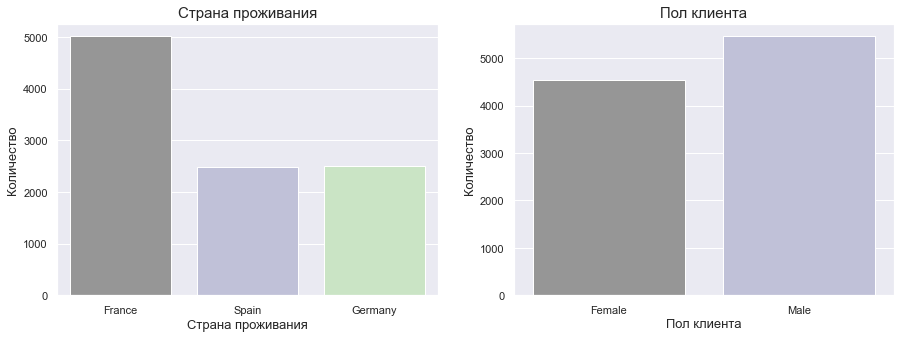

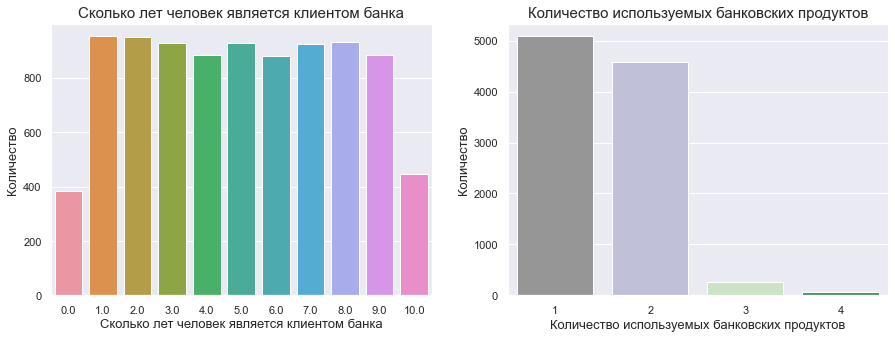

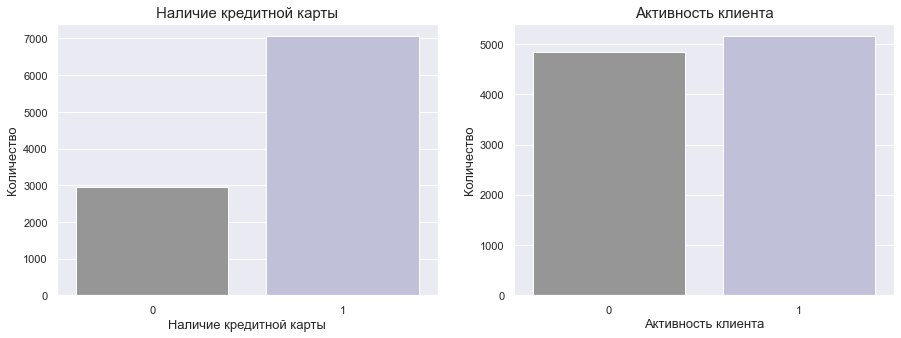

In [24]:
# построение графиков для категориальных признаков
for i in range(len(cat_features) // 2):
    show_double_countplots(cat_features[2 * i], cat_features[2 * i + 1])

Преобразуем категориальные признаки `geography` и `gender` в численные с использованием техники прямого кодирования (*One-Hot Encoding, OHE*). Используем атрибут `drop_first=True`, чтобы избавиться от одного лишнего столбца для кадого признака и не попасть в ловушку фиктивных признаков.

In [25]:
# преобразование категориальных признаков geography и gender в численные значения методом get_dummies()
df = pd.get_dummies(df, drop_first=True)

Так как в процессе преобразования был нарушен змеиный стиль в заголовках, то восстановим его.

In [26]:
# приведение названий заголовков столбцов к нижнему регистру
df.columns = df.columns.str.lower()

* В полученных данных мужчин примерно на `10%` больше, чем женщин.
* Около `50%` клиентов банка проживают во Франции и примерно по `25%` в Испании и Германии.
* По количеству лет, в течение которых люди являются клиентами банка, данные распределены почти равномерно. Исключениями являются лишь значения `0` и `10` лет, доля клиентов в которых в два раза ниже по сравнению с остальными значениями.
* Чаще всего клиенты пользуются `1-2` банковскими продуктами.
* Количество клиентов с кредитными картами более чем в три раза превышает количество клиентов банка, которые не имеют кредитных карт.
* Активные и неактивные клиенты распределены примерно поровну.
* Категориальные признаки `geography` и `gender` преобразованы в численные значения с использованием техники прямого кодирования (One-Hot Encoding, OHE).

### Изучение распределения целевого признака

Посмотрим на соотношение классов целевого признака.

In [27]:
# подсчёт долей каждого из классов целевого признака по отношению ко всем данным
target_rate = df['exited'].value_counts() / df.shape[0]
target_rate

0    0.7963
1    0.2037
Name: exited, dtype: float64

Для наглядности отобразим соотношение классов в целевом признаке на графике.

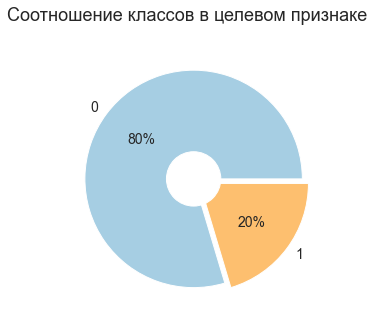

In [28]:
# построение круговой диаграммы для отображения соотношения классов в целевом признаке
theme = plt.get_cmap('Paired')

fig = plt.figure(figsize = (7, 5))
fig.suptitle('Соотношение классов в целевом признаке', fontsize=18)
plt.pie(
    target_rate,
    labels = target_rate.index,
    autopct='%.0f%%',
    textprops={'fontsize': 14},
    colors=[theme(1. * i / len(target_rate)) for i in range(len(target_rate))],
    explode=(0, 0.07)
)
centre_circle = plt.Circle((0,0), 0.25, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show();

* Целевой признак в рассматриваемых данных распределён следующим образом: `80%` данных соотвествует отрицательному классу `0`, в котором человек продолжает являться клиентом банка и `20%` соотвествуют положительному классу `1`, в котором отмечен факт ухода клиента определять который с необходимой точностью и должна научиться наша модель.

### Предобработка признака «Tenure»

На этапе обзора и изучения данных было установлено, что данный признак содержит около `9%` пропущенных значений. Попробуем заполнить данные значения на основе предсказаний предварительно обученной модели. Для этого отфильтруем данные, отобрав из них те, для которых известно значение `tenure`.

In [29]:
# отбор данных для обучения модели
data = df.loc[~df['tenure'].isna()]

Для обучения модели из полученного датасета отберём следуюшие признаки: `credit_score`, `age`, `balance`, `num_of_products`, `has_cr_card`, `is_active_member`, `estimated_salary`. Целевым признаком будет являться `tenure`.

In [30]:
# отбор целевого признака и признаков для обучения модели
features = data[['credit_score', 'age', 'balance', 'num_of_products',
                 'has_cr_card', 'is_active_member', 'estimated_salary']]
target = data['tenure'].astype('int64')

Перед обучением зафиксируем генератор псевдослучайных чисел для воспроизводимости результатов.

In [31]:
# сохраним случайное состояние (число) в переменную rnd
rnd = 123

In [32]:
# разделение выборки на тестовую и валидационную части
x_train, x_valid, y_train, y_valid = train_test_split(features, target, test_size=0.25, random_state=rnd)

Чтобы в процессе обучения моделей избежать необоснованного присвоения признакам бо́льшей важности из-за различий в масштабе данных проведём стандартизацию количественных признаков с помощью метода *StandardScaler()*.

In [33]:
# масштабирование количественных признаков
scaler = StandardScaler()

x_train[digit_features] = scaler.fit_transform(x_train[digit_features])
x_valid[digit_features] = scaler.fit_transform(x_valid[digit_features])

In [34]:
%%time
# обучение модели случайного леса с подстрокой различных гиперпараметров
best_rf_model = None
best_rf_result = 0

for est in range(20, 30, 2):
    for depth in range (7, 10):
        for crit in ['gini', 'entropy']:
            for min_split in range(2, 4):
                for min_leaf in range(3, 5):
                    rf_model = RandomForestClassifier(
                        random_state=rnd,
                        n_estimators=est,
                        max_depth=depth,
                        criterion=crit,
                        min_samples_split=min_split,
                        min_samples_leaf=min_leaf,
                        n_jobs=-1
                    )
                    
                    rf_model.fit(x_train, y_train)
                    predictions = rf_model.predict(x_valid)
                    result = accuracy_score(y_valid, predictions)
                    
                    if result > best_rf_result:
                        best_rf_model = rf_model
                        best_rf_result = result
            
print(f'Лучший результат для случайного леса {round(best_rf_result, 3)}\n ')
print(f'Лучший результат получен на модели с параметрами \n{best_rf_model.get_params()}')

Лучший результат для случайного леса 0.123
 
Лучший результат получен на модели с параметрами 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 24, 'n_jobs': -1, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}
CPU times: total: 22.2 s
Wall time: 5.24 s


Полученный показатель `accuracy` модели, равный `0.123` слишком мал для того, чтобы говорить о том, что модель обладает какой-либо прогностической способностью. Случайный выбор между 11 классами даёт средний результат `1 / 11 ≈ 0.091`.

In [35]:
%%time
from sklearn.model_selection import GridSearchCV


clf = RandomForestClassifier(random_state=rnd, n_jobs=-1)

params_grid = {
    'max_depth': range(7, 10),
    'n_estimators': range(20, 30, 2),
    'criterion': ['gini', 'entropy'],
    'min_samples_split': range(2, 4),
    'min_samples_leaf': range(3, 5),
   }

clf_grid = GridSearchCV(estimator=clf, param_grid=params_grid, scoring='accuracy', n_jobs=-1)
clf_grid.fit(x_train, y_train)
best_clf = clf_grid.best_estimator_

print(f'Лучший результат для случайного леса {round(clf_grid.best_score_, 3)}\n ')
print(f'Лучший результат получен на модели с параметрами \n{best_clf.get_params()}\n')

Лучший результат для случайного леса 0.106
 
Лучший результат получен на модели с параметрами 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 24, 'n_jobs': -1, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}

CPU times: total: 1.3 s
Wall time: 11.4 s


Проверим также какую точности `accuracy` можно получить на основе логистической регрессии. В качестве гиперпараметра модели будем изменять `solver` - алгоритм, используемый для решения задачи оптимизации, выбирая его из двух значений `liblinear` и `lbfgs`.

In [36]:
# обучение модели модели логистической регрессии с подстройкой гиперпараметра в виде выбора алгоритма оптимизации
best_reg_model = None
best_reg_result = best_c = 0

cs = [0.001, 0.2, 1]

for c in cs:
    reg_model = LogisticRegression(C=c, n_jobs=-1, random_state=rnd)
    reg_model.fit(x_train, y_train)
    predictions = reg_model.predict(x_valid)
    result = accuracy_score(y_valid, predictions)
    
    if result > best_reg_result:
        best_c = c
        best_reg_result = result
        best_reg_model = reg_model
            
print(f'Лучший результат для логистической регрессии {round(best_reg_result, 3)}\n')
print(f'при коэффициенте регуляризации С={best_c}')

Лучший результат для логистической регрессии 0.112

при коэффициенте регуляризации С=0.2


Логистическая регрессия выдала лучший результат для `accuracy`, равный `0.112` на алгоритме `lbfgs`, что ещё ниже значения модели на основе случайного леса.

Таким образом, заполнить пропущенные значения для признака `tenure` сколько-нибудь достоверными значеними не представляется возможным. Поэтому, заполним пропущенные данные значением `-1`, создав таким образом новую подкатегорию данных для пропущенных значений.

In [37]:
# преобразование признака tenure методом get_dummies()
df.loc[df['tenure'].isna(), 'tenure'] = -1
#df['tenure'] = df['tenure'].astype('int64').astype('object')
#df = pd.get_dummies(df, drop_first=True)

Для проверки результата, полученного после предобработки данных и подготовки их к обучению моделей, посмотрим на общий вид полученной таблицы и сводную информацию о ней.

In [38]:
# вывод первых строк из таблицы, полученной после предобработки данных
df.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_germany,geography_spain,gender_male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [39]:
# просмотр сводной информации о данных после предобработки данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             10000 non-null  float64
 3   balance            10000 non-null  float64
 4   num_of_products    10000 non-null  int64  
 5   has_cr_card        10000 non-null  int64  
 6   is_active_member   10000 non-null  int64  
 7   estimated_salary   10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   geography_germany  10000 non-null  uint8  
 10  geography_spain    10000 non-null  uint8  
 11  gender_male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


### Выводы по исследованию и предобработке данных

* Названия столбцов приведены к соотвествию змениному стилю.
* Признаки `RowNumber` (индекс строки в данных), `CustomerId` (уникальные идентификаторы клиентов) и `Surname` (фамилии клиентов) удалены из данных, так как они не оказывают влияния на целевой признак.
* Изучены количественные признаки. Наибольшее количество выбросов `3.59%` определно для признака `age` - возраста клиента. Выбросы оставлены как есть. Все количественные признаки стандартизированы и приведены к единому масштабу данных со средним = 0 и стандартным отклонением = 1. 
* Категориальные признаки `geography` и `gender` преобразованы методом прямого кодирования (*One-Hot Encoding*).
* Отношение отрицательного класса `0` к положительному классу `1` в целевом признаке `exited` составляет **4:1**.
* Попытка построить классификационную модель и на её основе заполнить пропущенные значения в признаке `tenure` в количестве `9%` от общего количества данных оказалась безуспешной. Точность `accuracy` для модели на основе случайного леса составила всего `0.123`, а для модели на основе логистической регрессии `0.106`, что незначительно превышает среднее случайное, равное `0.091`. Поэтому, пропущенные значения в данном признаке заполнены значениями `-1`.

## Разбиение на выборки и обучение на несбалансированных данных.

Так как целевой признак `exited` - факт того, что клиент ушёл соотвествует одному из двух фиксированных значений (отрицательному классу `0` - клиент не ушёл и «положительному» классу `1` - клиент ушёл), то предстоит решать задачу бинарной классификации. Перед обучением моделей необходимо разбить данные на обучающую, валидационную и тестовую выборки.

### Разбиение выборки на три части

Из исходного датасета выделим обучающие и целевой признаки в переменные `features` и `target` соотвественно. В качестве `target` будет выступать столбец с категориальным признаком `exited`. В `features` будут находится все остальные столбцы.

In [40]:
# Разделение выборки на обучающие и целевой признаки
features = df.drop(['exited'], axis=1)
target = df['exited']

Разделим исходные данные на три части: обучающую, валидационную и тестовую в соотношении 3:1:1 (60% данных составит обучающая часть и по 20% валидационная и тестовая).

In [41]:
# Разделение выборки на обучающую, валидационную и тестовую
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.2, random_state=rnd)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.25, random_state=rnd)

Проверка размеров полученных частей. 

In [42]:
# размер обучающей части
features_train.shape, target_train.shape

((6000, 11), (6000,))

In [43]:
# размер валидационной части
features_valid.shape, target_valid.shape

((2000, 11), (2000,))

In [44]:
# размер тестовой части
features_test.shape, target_test.shape

((2000, 11), (2000,))

Чтобы в процессе обучения моделей избежать необоснованного присвоения признакам бо́льшей важности из-за различий в масштабе данных проведём стандартизацию количественных признаков с помощью метода *StandardScaler()*.

In [45]:
# масштабирование количественных признаков
scaler = StandardScaler()

features_train[digit_features] = scaler.fit_transform(features_train[digit_features])
features_valid[digit_features] = scaler.fit_transform(features_valid[digit_features])
features_test[digit_features] = scaler.fit_transform(features_test[digit_features])

In [46]:
features_train

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
8189,0.652468,-1.698690,8.0,-1.213083,2,1,0,-0.535390,0,0,1
8845,0.796864,0.002583,1.0,0.886952,1,1,1,1.637287,1,0,0
1165,0.621526,0.947735,5.0,1.258423,2,0,0,1.681465,1,0,0
1742,-0.698668,1.420312,1.0,0.022130,1,0,0,0.672609,1,0,0
1139,0.776236,1.703857,1.0,0.538309,1,0,1,-1.715362,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
7359,0.147081,-0.280962,4.0,0.705746,2,1,0,-1.142899,0,0,1
9213,-0.698668,0.097099,4.0,0.103366,1,0,0,-0.323671,0,0,0
3533,0.446188,0.286129,5.0,-1.213083,1,0,1,-0.474483,0,0,0
5000,1.879836,2.743524,9.0,0.865491,2,0,1,-0.110656,1,0,0


Проверим соотношение классов целевого признака в тренировочной, валидационной и тестовой частях, полученных из исходного датафрейма после его разбиения. Так как подобные расчёты предполагается провести ещё несколько раз, создадим вспомогательную функцию *classes_balance()* для наглядного отображения баланса классов в целевом признаке.

In [47]:
# вспомогательная функция для отображения баланса классов в целевом признаке
def classes_balance(target_train, valid_sample=True):
    """
    input: target_train (pandas.Series)      - целевой признак;
           valid_sample (bool)               - наличие валидационной части данных.
    output: None
    description: Функция формирует таблицу, отображающую соотношение классов в целевом признаке в количественном
                 выражении и в долях от положительного класса.
    """
    train_cnt = f'{target_train.value_counts()[0]} : {target_train.value_counts()[1]}'
    if valid_sample:
        valid_cnt = f'{target_valid.value_counts()[0]} : {target_valid.value_counts()[1]}'
    test_cnt = f'{target_test.value_counts()[0]} : {target_test.value_counts()[1]}'
    
    train_rate = str(round(target_train.value_counts()[0] / target_train.value_counts()[1], 2))
    if valid_sample:
        valid_rate = str(round(target_valid.value_counts()[0] / target_valid.value_counts()[1], 2))
    test_rate = str(round(target_test.value_counts()[0] / target_test.value_counts()[1], 2))
    
    train_rate = f'{train_rate} : 1'
    if valid_sample:
        valid_rate = f'{valid_rate} : 1'
    test_rate = f'{test_rate} : 1'
    
    if valid_sample:
        rate_df = pd.DataFrame([[train_cnt, valid_cnt, test_cnt], [train_rate, valid_rate, test_rate]],
                           columns=['train_sample', 'valid_sample', 'test_sample'])
    else:
        rate_df = pd.DataFrame([[train_cnt, test_cnt], [train_rate, test_rate]],
                           columns=['train_sample', 'test_sample'])
    display(rate_df.T.rename(columns={0: 'class_counts', 1: 'rate'}))

In [48]:
# отображение баланса классов в целевом признаке после разделения исходного датафрейма
classes_balance(target_train=target_train)

,class_counts,rate
train_sample,4797 : 1203,3.99 : 1
valid_sample,1580 : 420,3.76 : 1
test_sample,1586 : 414,3.83 : 1


* Разбиение произошло корректно. Размеры полученных частей соотвествуют заданному соотношению **3:1:1**.
* Отношение классов в целевом признаке `exited`, примерно равное **4:1**, сохранилось в тренировочной, валидационной и тестовой частях после разбиения полного набора данных.
* Проведена стандартизация количественных признаков с помощью метода *StandardScaler()*, чтобы избежать ошибок обучения моделей, обусловленных раличным масштабом признаков.

### Решающее дерево

Обучим модель решающего дерева, используя *DecisionTreeClassifier()*. В качестве подстройки гиперапараметров будем изменять следующие значения:
* `max_depth` - максимальную глубину дерева;
* `criterion` - тип функции для измерения качества разделения (*gini* или *entropy*);
* `min_samples_split` - минимальное количество объектов в узле;
* `min_samples_leaf` - минимальное количество объектов в листе.

Критерием проверки качества модели будет `F1-мера` . Для удобства проведения экспериментов и сокращения количества кода при его многократном переиспользовании создадим вспомогательную функцию *decision_tree_model()*.

In [49]:
# функция обучение модели на основе решающего дерева с подстрокой гиперпараметров
def decision_tree_model(features_train, target_train,
                        depth_range=(2, 9), samples_split_range=(2, 4),
                        samples_leaf_range=(1, 4), cw=None, show_best_params=False):
    
    """
    input: features_train (pandas.DataFrame) - обучающая выборка признаков;
           target_train (pandas.Series)      - целевой признак;
           depth_range (tuple)               - диапазон изменения гиперпарааметра max_depth (максимальной глубины дерева);
           samples_split_range (tuple)       - диапазон изменения гиперпарааметра min_samples_split 
                                               (минимальное количество объектов в узле);
           samples_split_range (tuple)       - диапазон изменения гиперпарааметра min_samples_leaf 
                                               (минимальное количество объектов в листе);
           cw (str)                          - необходимость взвешивания классов (None или 'balanced');
           show_best_params (bool)           - отображение гиперпараметров лучшей модели.
    output: None
    description: Функция обучает модель решающего дерева на основе DecisionTreeClassifier() с подбором гиперпараметров
                 для получения лучших по метрикам F1 и ROC-AUC моделей.
                 Результат работы функции - вывод методом print() значений метрик F1 и ROC-AUC лучших моделей и значений
                 их гиперпараметров.
    """
    
    best_dt_model = None
    best_dt_by_f1 = 0
    
    # цикл перебора гиперпараметров для получения лучшей модели по заданной метрике качества
    for depth in range(depth_range[0], depth_range[1]):
        for criterion in ['gini', 'entropy']:
            for min_samples_split in range(samples_split_range[0], samples_split_range[1]):
                for min_samples_leaf in range(samples_leaf_range[0], samples_leaf_range[1]):
                    dt_model = DecisionTreeClassifier(max_depth=depth, class_weight=cw, random_state=rnd)
                    dt_model.fit(features_train, target_train)
                    
                    # прeдсказанные значения целевой переменной и метрики качества модели
                    predictions = dt_model.predict(features_valid)
                    result_f1 = f1_score(target_valid, predictions)
                    
                    # определение лучшей модели по F1 метрике
                    if result_f1 > best_dt_by_f1:
                        best_dt_model_f1 = dt_model
                        best_dt_by_f1 = result_f1
                        

    print('=' * 100)
    print(f'Лучший результат для решающего дерева по F1-мере: {round(best_dt_by_f1, 3)}')
    print('=' * 100)
    
    if show_best_params:
        print(f'\nЛучший результат получен на модели с параметрами: \n{best_dt_model_f1.get_params()}\n')
    
    # вычисление ROC-AUC метрики для лучшей модели
    predictions = best_dt_model_f1.predict(features_valid)
    probabilities_valid = best_dt_model_f1.predict_proba(features_valid)
    roc_auc = roc_auc_score(target_valid, probabilities_valid[:, 1])
    
    print('=' * 100)
    print(f'ROC-AUC метрика лучшей модели на основе дерева решений: {round(roc_auc, 3)}')
    print('=' * 100)
    
    return None

In [50]:
%%time
decision_tree_model(features_train, target_train, show_best_params=True)

Лучший результат для решающего дерева по F1-мере: 0.564

Лучший результат получен на модели с параметрами: 
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 123, 'splitter': 'best'}

ROC-AUC метрика лучшей модели на основе дерева решений: 0.817
CPU times: total: 688 ms
Wall time: 732 ms


* Лучшая модель на основе решающего дерева позволила достичь результата по *F1-мере*, равного `0.564`, что недостаточно для выполнения условия задания.
* Лучший результат по *ROC-AUC* метрике для этой модели составил `0.817`.
* Необходимо дальшейшее улучшение модели решающего дерева или использование других моделей для получения результата по *F1-мере*, удовлетворяющего условию задания.

### Случайный лес

Обучим модель на основе случайного леса, используя *RandomForestClassifier()*. В качестве подстройки гиперапараметров будем изменять следующие значения:
* `n_estimators` - количество деревьев в ансамбле;
* `max_depth` - максимальную глубину деревьев;
* `criterion` - тип функции для измерения качества разделения (*gini* или *entropy*);
* `min_samples_split` - минимальное количество объектов в узле деревьев;
* `min_samples_leaf` - минимальное количество объектов в листе.

Критерием проверки качества модели будет `F1-мера`. Для удобства проведения экспериментов и сокращения количества кода при его многократном переиспользовании создадим вспомогательную функцию *random_forest_model()*.

In [51]:
# функция обучение модели на основе случайного леса с подстрокой гиперпараметров
def random_forest_model(features_train, target_train, estimators_range=(25, 30),
                        depth_range=(14, 17), samples_split_range=(2, 4),
                        samples_leaf_range=(2, 5), cw=None, show_best_params=False):
    """
    input: features_train (pandas.DataFrame) - обучающая выборка признаков;
           target_train (pandas.Series)      - целевой признак;
           est_range (tuple)                 - диапазон изменения гиперпарааметра n_estimators (количество деревьев);
           depth_range (tuple)               - диапазон изменения гиперпарааметра max_depth (максимальной глубины дерева);
           samples_split_range (tuple)       - диапазон изменения гиперпарааметра min_samples_split 
                                               (минимальное количество объектов в узле);
           samples_split_range (tuple)       - диапазон изменения гиперпарааметра min_samples_leaf 
                                               (минимальное количество объектов в листе);
           cw (str)                          - необходимость взвешивания классов (None или 'balanced');
           show_best_params (bool)           - отображение гиперпараметров лучшей модели.
    output: None
    description: Функция обучает модель случайного леса на основе RandomForestClassifier() с подбором гиперпараметров
                 для получения лучших по метрикам F1 и ROC-AUC моделей.
                 Результат работы функции - вывод методом print() значений метрик f1 и ROC-AUC лучших моделей и значений
                 их гиперпараметров.
    """
    best_rf_model = None
    best_rf_by_f1 = 0
    
    # цикл перебора гиперпараметров для получения лучшей модели по заданной метрике качества
    for n_estimators in range(estimators_range[0], estimators_range[1], 2):
        for depth in range (depth_range[0], depth_range[1]):
            for criterion in ['gini', 'entropy']:
                for min_samples_split in range(samples_split_range[0], samples_split_range[1]):
                    for min_samples_leaf in range(samples_leaf_range[0], samples_leaf_range[1]):
                        rf_model = RandomForestClassifier(
                            n_estimators=n_estimators,
                            max_depth=depth,
                            criterion=criterion,
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            class_weight=cw,
                            random_state=rnd,
                            n_jobs=-1
                        )
                        rf_model.fit(features_train, target_train)
                        
                        # прeдсказанные значения целевой переменной и метрики качества модели
                        predictions = rf_model.predict(features_valid)
                        result_f1 = f1_score(target_valid, predictions)
                        
                        # определение лучшей модели по F1 метрике
                        if result_f1 > best_rf_by_f1:
                            best_rf_model_f1 = rf_model
                            best_rf_by_f1 = result_f1
                            
    print('=' * 100)
    print(f'Лучший результат для случайного леса по F1-мере: {round(best_rf_by_f1, 3)}')
    print('=' * 100)
    
    if show_best_params:
        print(f'\nЛучший результат получен на модели с параметрами: \n{best_rf_model_f1.get_params()}\n')
    
    # вычисление ROC-AUC метрики для лучшей модели
    predictions = best_rf_model_f1.predict(features_valid)
    probabilities_valid = best_rf_model_f1.predict_proba(features_valid)
    roc_auc = roc_auc_score(target_valid, probabilities_valid[:, 1])
    
    print('=' * 100)
    print(f'ROC-AUC метрика лучшей модели на основе случайного леса: {round(roc_auc, 3)}')
    print('=' * 100)
    
    return None

In [52]:
%%time
random_forest_model(features_train, target_train, show_best_params=True)

Лучший результат для случайного леса по F1-мере: 0.585

Лучший результат получен на модели с параметрами: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 25, 'n_jobs': -1, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}

ROC-AUC метрика лучшей модели на основе случайного леса: 0.837
CPU times: total: 19.3 s
Wall time: 5.16 s


* Лучшая модель на основе случайного леса позволила достичь результата по *F1-мере*, равного `0.585`, что недостаточно для выполнения условия задания.
* Лучший результат по *ROC-AUC* метрике для этой модели составил `0.837`.
* Необходимо дальшейшее улучшение модели случайного леса или использование другой модели для получения результата по *F1-мере*, удовлетворяющего условию задания.

### Логистическая регрессия

Обучим модель на основе логистической регрессии, используя *LogisticRegression()*. В качестве подстройки гиперапараметров будем изменять значение `С` - обратной силы регуляризации.

Критерием проверки качества модели будет `F1-мера`.

In [53]:
# обучение модели модели логистической регрессии с подстройкой гиперпараметров
best_reg_model = None
best_reg_by_f1 = best_reg_by_auc = 0

for с in np.linspace(0.001, 10 , 100):
        reg_model = LogisticRegression(C=с, n_jobs=-1, random_state=rnd)
        reg_model.fit(features_train, target_train)
        
        # прeдсказанные значения целевой переменной и метрики качества модели
        predictions = reg_model.predict(features_valid)
        result_f1 = f1_score(target_valid, predictions)
        
        # определение лучшей модели по f1 метрике
        if result_f1 > best_reg_by_f1:
            best_reg_model_f1 = reg_model
            best_reg_by_f1 = result_f1
            

print('=' * 100)
print(f'Лучший результат для логистической регрессии по F1-мере: {round(best_reg_by_f1, 3)}')
print('=' * 100)

print(f'\nЛучший результат получен на модели с параметрами: \n{best_reg_model_f1.get_params()}\n')
    
# вычисление ROC-AUC метрики для лучшей модели
predictions = best_reg_model_f1.predict(features_valid)
probabilities_valid = best_reg_model_f1.predict_proba(features_valid)
roc_auc = roc_auc_score(target_valid, probabilities_valid[:, 1])

print('=' * 100)
print(f'ROC-AUC  метрика лучшей модели на основе логистической регрессии: {round(roc_auc, 3)}')
print('=' * 100)

Лучший результат для логистической регрессии по F1-мере: 0.281

Лучший результат получен на модели с параметрами: 
{'C': 0.30400000000000005, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 123, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

ROC-AUC  метрика лучшей модели на основе логистической регрессии: 0.761


* Логистическая регрессия показала значительно более худшие результаты, чем дерево решений и случайный лес.
* Результат лучшей модели на основе логистической регрессии после подбора гиперапараметров равен по *F1-мере* `0.281`, что значительно ниже минимального порогового значения по условию задания. Лучший результат по *ROC-AUC* метрике составил `0.761`.

### Выводы по обученным моделям

* Исходные данные разделены на обучающую, валидационную и тестовую выборки в соотношении 3:1:1 соотвественно. Изначальное соотношение классов в целевом признаке `exited`, примерно равное **4:1**, сохранилось в тренировочной, валидационной и тестовой частях и после разбиения полного набора данных.
* На несбалансированных данных были обучены модели на основе *решающего дерева*, *случайного леса* и *логистической регрессии*. Максимального значения **F1-меры**, равного `0.585`, на тестовой выборке удалось достичь для модели на основе случайного леса. Но, его оказалось недостаточно для выполнения условия задания.
* Качество моделей также оценивалось по метрике **ROC-AUC**. Максимальное значение по данной метрике, равное `0.716`, также было достигнуто для модели на основе случайного леса.
* Максимальный результат для модели на основе логистической регрессии оказался почти в два раза более низкий по F1-мере, чем результаты для моделей на основе решающего дерева и случайного леса.
* Для возможного улучшения качества моделей и получения значения F1-меры, удовлетворяющего условию задания, проведём исследование по влиянию дисбаланса классов на метрики качества моделей.

## Работа с дисбалансом, обучение, валидация и тестирование моделей.

Как установлено на этапе исследования и преобработки данных, соотношение классов в целевом признаке равно `4:1` (для классов `0` и `1` соотвественно). В рамках исследования влияния дисбаланса классов попробуем следующие методы борьбы с данным явлением:
* `взвешивание классов` с использованием параметра *class_weight='balanced'*;
* `upsampling` или увеличение доли редкого класса в выборке;
* `downsampling` или уменьшение доли более часто встречающегося класса в выборке.

Сравним полученные результаты для моделей решающего дерева и случайного леса.

### Взвешивание классов

#### Взвешивание классов для модели решающего дерева

Проверим влияние взвешивания классов на метрики качества модели на основе решающего дерева.

In [54]:
# обучение модели на основе решающего дерева с использованием взвешивания классов
decision_tree_model(features_train,  target_train, cw='balanced', show_best_params=True)

Лучший результат для решающего дерева по F1-мере: 0.545

Лучший результат получен на модели с параметрами: 
{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 123, 'splitter': 'best'}

ROC-AUC метрика лучшей модели на основе дерева решений: 0.813


* Взвешивание классов для решающего дерева привело к снижению *F1-меры*, по сравнению с той, что была получена для решающего дерева без взвешивания, с `0.564` до `0.545`. *ROC-AUC* метрика при этом также снизилась со значения `0.817` до `0.813`.

#### Взвешивание классов для модели случайного леса

Проверим влияние взвешивания классов на метрики качества модели на основе случайного леса.

In [55]:
# обучение модели на основе случайного леса с использованием взвешивания классов
random_forest_model(features_train, target_train, estimators_range=(27, 32), cw='balanced', show_best_params=True)

Лучший результат для случайного леса по F1-мере: 0.608

Лучший результат получен на модели с параметрами: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 16, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 29, 'n_jobs': -1, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}

ROC-AUC метрика лучшей модели на основе случайного леса: 0.834


* Взвешивание классов для случайного леса повысило значение *F1-меры*, которая увеличилась с `0.585` до значения `0.606`. *ROC-AUC* метрика при этом снизилась со значения `0.837` до `0.834`.
* Полученное значение *F1-меры* для модели случайного леса со взвешиванием классов удовлетворяет условию задания.

#### Взвешивание классов для модели логистической регрессии

In [56]:
# обучение модели модели логистической регрессии с подстройкой гиперпараметров
best_reg_model = None
best_reg_by_f1 = best_reg_by_auc = 0

cs = [0.001, 0.1, 1]

for с in cs:
        reg_model = LogisticRegression(C=с, class_weight='balanced', n_jobs=-1, random_state=rnd)
        reg_model.fit(features_train, target_train)
        
        # прeдсказанные значения целевой переменной и метрики качества модели
        predictions = reg_model.predict(features_valid)
        result_f1 = f1_score(target_valid, predictions)
        
        # определение лучшей модели по f1 метрике
        if result_f1 > best_reg_by_f1:
            best_reg_model_f1 = reg_model
            best_reg_by_f1 = result_f1
            

print('=' * 100)
print(f'Лучший результат для логистической регрессии по F1-мере: {round(best_reg_by_f1, 3)}')
print('=' * 100)

print(f'\nЛучший результат получен на модели с параметрами: \n{best_reg_model_f1.get_params()}\n')
    
# вычисление ROC-AUC метрики для лучшей модели
predictions = best_reg_model_f1.predict(features_valid)
probabilities_valid = best_reg_model_f1.predict_proba(features_valid)
roc_auc = roc_auc_score(target_valid, probabilities_valid[:, 1])

print('=' * 100)
print(f'ROC-AUC  метрика лучшей модели на основе логистической регрессии: {round(roc_auc, 3)}')
print('=' * 100)

Лучший результат для логистической регрессии по F1-мере: 0.509

Лучший результат получен на модели с параметрами: 
{'C': 0.001, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 123, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

ROC-AUC  метрика лучшей модели на основе логистической регрессии: 0.761


* Взвешивание классов для логистической регрессии повысило значение *F1-меры*, которая увеличилась с `0.281` до значения `0.509`. *ROC-AUC* метрика при не изменилась и осталась равной `0.761`.
* Несмотря на то, что взвешивание классов для логистической регрессии обеспечило наибольшее относительно других моделей повышение *F1-меры*, полученное значение всё еще является самым низким по сравнению с моделями на основе дерева решений и случайного леса. По этой причине работать дальше над улучшением модели на основе логистической регрессии представляется нецелесообразным.

### Увеличение выборки

Для уменьшения влияния дибаланса классов применим метод **upsampling** при котором искуственно увеличим долю объектов более редкого класса. Создадим вспомогательную функцию *upsample()* для решения этой задачи.

In [57]:
# вспомогательная функция для увеличения количества объектов редкого класса в выборке
def upsample(features, target, repeat):
    """
    input: features (pandas.DataFrame)            - обучающий набор признаков;
           target (pandas.Series)                 - целевой признак;
           repeat (digit)                         - множитель - число во сколько раз необходимо увеличить редкий класс.
    output: features_upsampled (pandas.DataFrame) - изменённый обучающий набор признаков;
            target_upsampled (pandas.Series)      - изменённый целевой признак.
    description: Функция разделяет обучающую выборку на отрицательные и положительные классы, копирует заданное значеним
                 repeat количество раз объекты редкого класса, создаёт из полученных данных новую выборку и перемешивает
                 её.
    """
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=rnd)
    
    return features_upsampled, target_upsampled

Воспользуемся созданной функцией и увеличим долю объектов редкого класса в обучающей выборке.

In [58]:
# создание обучающей выборки со сбалансировнными методом upsampling классами
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

С помощью созданной ранее функции *classes_balance()* проверим соотношение классов в данных после применения техники *upsampling*.

In [59]:
# отображение баланса классов в целевом признаке после применения техники upsampling
classes_balance(target_train=target_upsampled)

,class_counts,rate
train_sample,4797 : 4812,1.0 : 1
valid_sample,1580 : 420,3.76 : 1
test_sample,1586 : 414,3.83 : 1


#### Увеличение выборки для модели решающего дерева

Проверим влияние увеличения выборки на метрики качества модели на основе решающего дерева.

In [60]:
# обучение модели на основе решающего дерева с использованием увеличения выборки
decision_tree_model(features_upsampled, target_upsampled, show_best_params=True)

Лучший результат для решающего дерева по F1-мере: 0.546

Лучший результат получен на модели с параметрами: 
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 123, 'splitter': 'best'}

ROC-AUC метрика лучшей модели на основе дерева решений: 0.796


* По сравнению с аналогичными результатами, полученными для модели на основе дерева решений, обученного на несбалансированных данных, увеличение выборки привело к снижению значения *F1-меры* с `0.564` до `0.546`. *ROC-AUC* метрика при этом снизилась со значения `0.817` до `0.796`.

#### Увеличение выборки для модели случайного леса

Проверим влияние увеличения выборки на метрики качества модели на основе случайного леса.

In [61]:
# обучение модели на основе случайного леса с использованием взвешивания классов
random_forest_model(features_upsampled, target_upsampled, estimators_range=(26, 32), samples_leaf_range=(4, 7),
                    show_best_params=True)

Лучший результат для случайного леса по F1-мере: 0.602

Лучший результат получен на модели с параметрами: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 26, 'n_jobs': -1, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}

ROC-AUC метрика лучшей модели на основе случайного леса: 0.833


* Увеличение выборки для случайного леса повысило значение *F1-меры*, которая увеличилась с `0.585` до значения `0.602` по сравнению с аналогичной моделью, обученной на несбалансированных данных. *ROC-AUC* метрика при этом снизилась со значения `0.837` до `0.833`.
* С увеличением выборки для модели случайного леса по сравнению с моделью случайного леса со взвешиванием весов произошло снижение значения *F1-меры* с `0.606` до `0.602`.

### Уменьшение выборки

Противоположным увеличению выборки явлется подход уменьшения влияния дибаланса классов техникой **downsampling** при котором происходит снижение доли объектов более часто встречающегося класса. Для применения этой техники к исследуемым данным создадим вспомогательную функцию *downsampling()*.

In [62]:
# вспомогательная функция для уменьшения количества объектов более частого встречающегося класса в выборке
def downsample(features, target, fraction):
    """
    input: features (pandas.DataFrame)            - обучающий набор признаков;
           target (pandas.Series)                 - целевой признак;
           fraction (digit)                       - доля, которую необходимо оставить от объектов более часто
                                                    представленного в выборке класса.
    output: features_upsampled (pandas.DataFrame) - изменённый обучающий набор признаков;
            target_upsampled (pandas.Series)      - изменённый целевой признак.
    description: Функция разделяет обучающую выборку на отрицательные и положительные классы, случайным образом 
                 отбрасывает часть объектов из более более часто представленного в выборке класса пока количествво 
                 объектов данного класса не станет соотвествовать заданному аргументом fraction значению, создаёт 
                 из полученных данных новую выборку и перемешивает её.
    """
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=rnd)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=rnd)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=rnd)
    
    return features_downsampled, target_downsampled

Воспользуемся созданной функцией и уменьшим долю объектов более частого встречающегося класса в обучающей выборке, чтобы соотношение классов было равным.

In [63]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

С помощью созданной ранее функции *classes_balance()* проверим соотношение классов в данных после применения техники *downsampling*.

In [64]:
# отображение баланса классов в целевом признаке после применения техники downsampling
classes_balance(target_train=target_downsampled)

,class_counts,rate
train_sample,1199 : 1203,1.0 : 1
valid_sample,1580 : 420,3.76 : 1
test_sample,1586 : 414,3.83 : 1


#### Уменьшение выборки для модели решающего дерева

Проверим влияние уменьшения выборки на метрики качества модели на основе решающего дерева.

In [65]:
# обучение модели на основе решающего дерева с использованием уменьшения выборки
decision_tree_model(features_downsampled, target_downsampled, show_best_params=True)

Лучший результат для решающего дерева по F1-мере: 0.55

Лучший результат получен на модели с параметрами: 
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 123, 'splitter': 'best'}

ROC-AUC метрика лучшей модели на основе дерева решений: 0.812


* По сравнению с аналогичными результатами, полученными для модели на основе дерева решений, обученного на несбалансированных данных, уменьшение выборки привело к снижению *F1-меры*, которая для лучшей модели уменьшилась с `0.564` до `0.55`.
* *ROC-AUC* метрика при этом, достигнув значения `0.812` также снизилась со значения, равного `0.837`, полученного на несбалансированных данных.

#### Уменьшение выборки для модели случайного леса

Проверим влияние уменьшения выборки на метрики качества модели на основе случайного леса.

In [66]:
# обучение модели на основе случайного леса с использованием взвешивания классов
random_forest_model(features_downsampled, target_downsampled, estimators_range=(22, 28), show_best_params=True)

Лучший результат для случайного леса по F1-мере: 0.585

Лучший результат получен на модели с параметрами: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 22, 'n_jobs': -1, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}

ROC-AUC метрика лучшей модели на основе случайного леса: 0.835


* Уменьшение выборки для случайного леса повысило значение *F1-меры*, которая увеличилась с `0.564` до значения `0.585` по сравнению с аналогичной моделью, обученной на несбалансированных данных. При этом по сравнению с техникой обработки несбалансированных данных, заключающейся в увеличении выборки, *F1-мера* снизилась с `0.602` до `0.585`.
* Из предыдущего пункта можно сделать вывод, что в процессе уменьшения выборки было удалено слишком много данных, валидационная выборка превзошла по своим размерам больше обучающую, что негативно сказалось на показателях качества модели, обученной на выборке пониженной размерности.
* *ROC-AUC* метрика при этом повысилась со значения `0.833` до `0.835`.

### Выводы по работе с дисбалансом классов

* На моделях решающего дерева и случайного леса проверены результаты использования методов борьбы с дисбалансом классов таких как: взвешивание классов, увеличение (*upsampling*) и уменьшение (*downsampling*) выборки.
* Использование взвешивания классов для случайного леса позволило достичь значения *F1-меры* на валидационной выборке, равного `0.606`, что удовлетворяет условию задания (`>0.59`). Для решающего дерева использование взвешивания классов на значение *F1-меры* повлияло в худщую сторону в результате чего данная метрика снизилась с `0.564` до `0.545`.
* Применение метода увеличения выборки (*upsampling*) для борьбы с дисбалансом классов обеспечило достижение значения *F1-меры*, равного `0.602`. При этом также *ROC-AUC* метрика снизилась со значения `0.817` до `0.796`. Для модели на основе решающего дерева использование данного метода привело к снижению значения *F1-меры* с `0.564` до `0.546`. *ROC-AUC* метрика при этом снизилась со значения `0.837` до `0.833`.
* Применение метода уменьшения выборки (*downsampling*) для дерева решений привело к увеличению *F1-меры* с `0.546` до `0.55` и повышению *ROC-AUC* с `0.796` до `0.812` по сравнению с аналогичной моделью, обученной на *upsampling* выборке. Использование этого же метода для борьбы с дисбалансом классов для модели на основе случайного леса также привело к снижению *F1-меры* с `0.602` до `0.585` и повышению *ROC-AUC* с `0.833` до `0.835` по сравнению с аналогичной моделью, обученной на *upsampling* выборке.
* Уменьшение выборки, как следует из предыдущего пункта, снижает качество по *F1-мере*, так как она лишается значительной части обучающих данных, но при этом также незначительно возраставет *ROC-AUC* метрика, так как выборка становится меньше и вероятность ошибки модели снижается.

## Финальное тестирование

Финальное тестирование проведём на 20% выборке из исходных данных, которая была выделена для тестирования в п.3.1. Для тестирования возьмём модель решающего дерева с уменьшением выборки (*downsampling*) с определёнными в п.4.3.1 гиперпараметрами и модель на основе случайного леса с увеличеним выборки (*upsampling*) с определёнными в п.4.2.2 гиперпараметрами.

### Финальное тестирование модели на основе решающего дерева

Обучим решающее дерево с гиперпараметрами, на которых ранее было достигнуто максимальное значение *F1-меры*:
* `criterion='gini'`;
* `max_depth=5`;
* `min_samples_split=2`;
* `min_samples_leaf=1`.

После обучения сделаем прогноз на тестовой выборке и определим для обученной модели выбранные метрики качества *F1-меру* и *ROC-AUC*.

In [67]:
# обучение модели на основе дерева решений с заданными гиперпараметрами
model_dt_final = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=rnd
)

model_dt_final.fit(features_downsampled, target_downsampled)

# прогноз на тестовой выборке
predictions = model_dt_final.predict(features_test)

# определение метрик качества - F1-меры и ROC-AUC
f1 = round(f1_score(target_test, predictions), 3)
probabilities_valid = model_dt_final.predict_proba(features_valid)
roc_auc = round(roc_auc_score(target_valid, probabilities_valid[:, 1]), 3)

print('Значения метрик на финальном тестировании решающего дерева:')
print(f' • F1 = {f1} \n • ROC-AUC = {roc_auc}')

Значения метрик на финальном тестировании решающего дерева:
 • F1 = 0.583 
 • ROC-AUC = 0.812


* На финальном тестировании модели на основе дерева решений значение *F1-меры* повысилось с `0.55` до `0.583` по сравнению с этой же метрикой на валидационной выборке.
* *ROC-AUC* метрика при этом не изменилась и осталась равной `0.812`.

### Финальное тестирование модели на основе случайного леса

Обучим случайный лес с гиперпараметрами, на которых ранее было достигнуто максимальное значение *F1-меры*:
* `n_estimators=28`;
* `criterion='entropy'`;
* `max_depth=14`;
* `min_samples_split=2`;
* `min_samples_leaf=5`.

После обучения сделаем прогноз на тестовой выборке и определим для обученной модели выбранные метрики качества *F1-меру* и *ROC-AUC*.

In [68]:
# обучение модели на основе случайного леса с заданными гиперпараметрами
model_rf_final = RandomForestClassifier(
    n_estimators=28,
    criterion='entropy',
    max_depth=14,
    min_samples_split=2,
    min_samples_leaf=5,
    random_state=rnd
)

model_rf_final.fit(features_upsampled, target_upsampled)

# прогноз на тестовой выборке
predictions = model_rf_final.predict(features_test)

# определение метрик качества - F1-меры и ROC-AUC
f1 = round(f1_score(target_test, predictions), 3)
probabilities_valid = model_rf_final.predict_proba(features_valid)
roc_auc = round(roc_auc_score(target_valid, probabilities_valid[:, 1]), 3)

print('Значения метрик на финальном тестировании случайного леса:')
print(f' • F1 = {f1} \n • ROC-AUC = {roc_auc}')

Значения метрик на финальном тестировании случайного леса:
 • F1 = 0.631 
 • ROC-AUC = 0.839


Лучшей моделью с `F1-мерой`, равной `0.631`, стала модель случайного леса, обученная на данных дисбаланс в которых был устранён с помощью метода повышения выборки (*upsampling*). Построим для этой модели график *ROC-AUC*.

C:\Users\Oleg\AppData\Local\Temp\ipykernel_20748\2666769636.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='r')


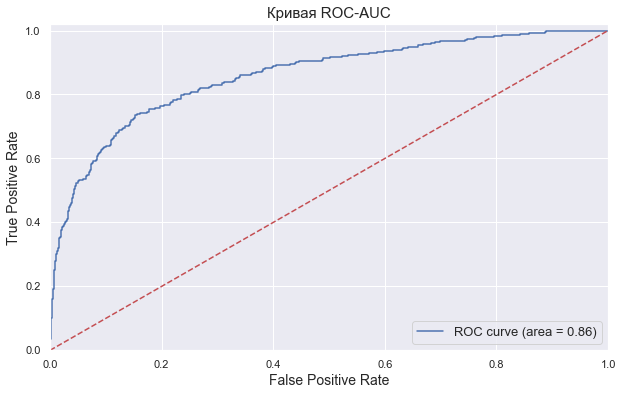

In [69]:
# определение вероятности принадлежности классам 0 и 1
ypred_prob = model_rf_final.predict_proba(features_test)

# данные для построения ROC-AUC кривой
fpr, tpr, thresholds = roc_curve(target_test, ypred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# построение графика ROC-AUC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc), color='b')
plt.plot([0, 1], [0, 1], 'k--', color='r')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Кривая ROC-AUC', fontsize=15)
plt.legend(loc='lower right', fontsize=13)
plt.show();

* На финальном тестировании модели на основе случайного леса значение *F1-меры* повысилось с `0.602` до `0.631` по сравнению с этой же метрикой случайного леса на валидационной выборке.
* *ROC-AUC* метрика при этом также возросла с `0.833` до `0.839`.
* Построен график ROC-AUC кривой, который демонстрирует значимое отличие результатов работы модели от случайных величин.

### Выводы по финальному тестированию

* Для финального тестирования отобраны две модели:
    * решающего дерева с уменьшением выборки (*downsampling*) с определёнными в ранее гиперпараметрами;
    * модель на основе случайного леса с увеличеним выборки (*upsampling*), гиперпараметры которой также были подобраны ранее.
* Проведено финальное тестирование модели на основе дерева решений с определёнными на предыдущих этапах гиперпараметрами. Выполнен прогноз на тестовой выборке и определены меры качества *F1-мера* и *ROC-AUC*. Значение *F1-меры* повысилось с `0.55` до `0.583` по сравнению с этой же метрикой на валидационной выборке. *ROC-AUC* метрика не измениласт и осталась равной `0.812`.
* Проведено финальное тестирование модели на основе случайного леса с определёнными на предыдущих этапах гиперпараметрами. Выполнен прогноз на тестовой выборке и определены меры качества *F1-мера* и *ROC-AUC*. Значение *F1-меры* повысилось с `0.602` до `0.631` по сравнению с этой же метрикой случайного леса на валидационной выборке. *ROC-AUC* метрика возросла с `0.833` до `0.839`.
* Построен график ROC-AUC кривой, который демонстрирует значимое отличие результатов работы модели от случайных значений.

## Общие выводы

1. Полученные в файлe `Churn.csv` исторические данные о поведении клиентов банка были успешно загружены и проанализированы. В полученных данных содержатся `10000` записей. Полных дубликатов не обнаружено. Присутствуют многочисленные нарушения стиля заголовков и пропущенные данные в столбце `Tenure` (сколько лет человек является клиентом банка) в количестве `9%`. Установлена необходимость исследования и предобработки данных.


2. Выполнена предобработка данных :
    * названия столбцов приведены к соотвествию змениному стилю;
    * столбцы `RowNumber` (индекс строки в данных), `CustomerId` (уникальные идентификаторы клиентов) и `Surname` (фамилии клиентов) удалены из данных как не оказывающие влияния на целевой признак;
    * категориальные признаки `geography` и `gender` преобразованы методом прямого кодирования (*One-Hot Encoding*);
    * определено отношение `4:1` отрицательного класса `0` к положительному классу `1` в целевом признаке `exited`;
    * попытка заполнения пропущенных значений `tenure` на основе прогнозов модели машинного обучения оказалась неудачной так как получены низкие значения точности - `0.123` для случайного леса и `0.112` для логистичской регрессии, что не сильно лучше случайного заполнения, средняя точность которого будет равна `0.091`;
    * пропущенные значения в признаке `tenure` заполнены значениями `-1`.


3. Проведено обучение моделей на несбалансированных данных:
    * исходные данные разделены на обучающую, валидационную и тестовую выборки в соотношении 3:1:1;
    * все количественные признаки в полученных выборках стандартизированы и приведены к единому масштабу данных;
    * на несбалансированных данных были обучены модели на основе *решающего дерева*, *случайного леса* и *логистической регрессии*;
    * максимального значения *F1-меры*, равного `0.585`, на валидационной выборке удалось достичь для модели на основе случайного леса, но оно оказалось недостаточным для выполнения условия задания;
    * максимальное значение *ROC-AUC*, равное `0.837`, также было достигнуто для модели на основе случайного леса;
    * лучший результат по *F1-мере* после подбора гиперпараметров для модели на основе логистической регрессии оказался почти в два раза более низкий по сравнению с результатами для моделей на основе решающего дерева и случайного леса.
    

4. Изучено влияние дисбаланса классов на метрики качества моделей:
    * в качестве методов работы с дибалансом классов использованы взвешивание классов, увеличение (*upsampling*) и уменьшение (*downsampling*) выборки;
    * для решающего дерева использование взвешивания классов на значение *F1-меры* повлияло в худщую сторону и данная метрика снизилась с `0.564` до `0.545`
    * использование взвешивания классов для случайного леса позволило достичь значения *F1-меры* на валидационной выборке, равного `0.606`, что удовлетворяет условию задания (`>0.59`);
    * взвешивание классов для логистической регрессии повысило значение *F1-меры*, которая увеличилась с `0.281` до значения `0.509`, что признано неудовлетворительным результатам и дальнейшие работы по улучшению логистической регрессии не проводились;
    * максимального значения *F1-меры*, равного `0.606`, на валидационной выборке удалось достичь для модели на основе решающего дерева со взвешиванием классов;
    * максимальное значение *ROC-AUC*, равное `0.837`, было получено для модели на основе случайного леса на несьалансированных данных;
    * сводные параметры двух лучших моделей по *F1-мере* и *ROC-AUC*:
        * **Случайный лес со *взвешиванием***:
            * **F1 = 0.606**
            * **ROC-AUC = 0.834**
        * **Случайный лес на несбалансированных данных:
            * **F1 = 0.585**
            * **ROC-AUC = 0.837**


5. Осуществлено финальное тестирование моделей:
    * финальное тестирование проведено на тестовой выборке размером 20% от исходных данных, которых модели до этого еще не "видели";
    * для тестирования отобраны две модели: решающего дерева с уменьшением выборки (*downsampling*) и модель на основе случайного леса с увеличеним выборки (*upsampling*), гиперпараметры которых были подобраны ранее;
    * на финальном тестировании необходимое по условию задания значение *F1-меры* (`>0.59`) получено только для модели на основе случайного леса, при этом удалось повысить обе метрики качества (*F1* и *ROC-AUC*);
    * значения метрик на финальном тестировании случайного леса:
        * **Случайный лес с *upsampling*** на финальном тестировании:
            * **F1 = 0.631**
            * **ROC-AUC = 0.839**
    * для протестированной модели случайного леса построен график ROC-AUC кривой, который демонстрирует значимое отличие результатов работы модели от случайных.
    
    
6. Практически во всех случаях случайный лес по сравнению с решающим деревом и логистической регрессией демонстрирует более высокие метрики качества моделей и является более сильным методом классификации применительно к рассмотренной задаче.